# Reto I: Deep Learning

In [119]:
#Libraries required
import pandas as pd
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.multivariate.pca import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import os
import sys
from scipy.stats import zscore
from torchsummary import summary  # Display model summary
from tqdm.notebook import tqdm  # Display progress bar

In [120]:
#Let's read the data
data=pd.read_csv('/content/drive/MyDrive/Deep Learning/Semana 1/data.csv')

In [121]:
#Let's take a look into the dataset
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [122]:
#Describing our dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [123]:
#Let's drop the null values from original data
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(columns=['index'],inplace=True)

In [124]:
#Funtion to calculate current % of missing values in a dataframe
def missing_pct(df):
  pct=(df.isna().sum().sum())/(df.shape[0]*df.shape[1])
  return pct*100

In [125]:
#Taken from script shared in lesson
def normalized_mrse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    range_y = np.max(y_true) - np.min(y_true)
    nrmse = rmse / range_y
    return nrmse

In [126]:
def score(dict_1,dict_2,a_1,a_2):
  # Initialize an empty list to store NRMSE values for each column
  nrmse_values_pca = []

  # Iterate over each column with missing values
  for column in A.columns:
      # Calculate NRMSE for the current column
      nrmse_col = normalized_mrse(dict_2[a_2][column],dict_1[a_1][column])
      # Append the NRMSE for the current column to the list
      nrmse_values_pca.append(nrmse_col)


  # Calculate the final score as the mean of all NRMSE values
  score_final = np.mean(nrmse_values_pca)
  return score_final

In [127]:
#Let's create a function to delete entries randomly

#If parameter rigid is True we will consider the existing null values as part of the % of entries to be deleted
#Parameter pc is the % of entries to be removed (0%-100%).
#df is the dataset from which entries will be removed randomly.

def make_mess(df,pc,rigid):
  original=df.copy()
  entries=df.shape[0]*df.shape[1]
  #Calculating entries to be remove:
  to_miss=math.ceil(entries*pc/100)

  if rigid:
    to_miss=to_miss-df.isna().sum().sum()

  #Creating reference dataframe: coordinates [r,c] with index 0,..., df.shape[0]

  ref_df=pd.DataFrame(columns=['Row','Col'])

  for r in range(df.shape[0]):
    for c in range(df.shape[1]):
      ref_df.loc[len(ref_df.index)]=[r,c]

  #Picking up the of rows to be deleted in a random fashion


  del_ref=ref_df.sample(n=to_miss, random_state=12)
  del_ref.reset_index(inplace=True)

  #Deleting entries
  for i in range(to_miss):
    df.iloc[del_ref.loc[i,'Row'],del_ref.loc[i,'Col']]=np.nan

  check_col=original.shape[0]
  check_row=df.shape[1]

  for i in df.columns:
    #Check for entire column
    e=df[i].isna().sum()
    if e==check_col:
      df=make_mess(original.copy(),pc,rigid)

      #Check for entire row
  for i in df.index:
    v=df.loc[i,:].isna().sum()
    if v ==check_row:
      df=make_mess(original.copy(),pc,rigid)

  return df

In [128]:
#Function to populate missing values (with average/normal sampling)

def populate(df,how):

  if how=='avg':

    for c in df.columns:
      value=df[c].mean()
      df[c].fillna(value,inplace=True)

  elif how=='gauss':

    for c in df.columns:
      index = df[df[c].isna()].index
      value = np.random.normal(loc=df[c].mean(), scale=df[c].std(), size=df[c].isna().sum())
      df[c].fillna(pd.Series(value, index=index), inplace=True)

  elif how=='median':

    for c in df.columns:
      value=df[c].median()
      df[c].fillna(value,inplace=True)

  return df


In [129]:
#Creating dataset A with 10% missing entries
A=make_mess(data[data.columns[:13]].copy(),10,True)

In [130]:
#Summary of A
A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       271 non-null    float64
 1   sex       267 non-null    float64
 2   cp        266 non-null    float64
 3   trestbps  269 non-null    float64
 4   chol      262 non-null    float64
 5   fbs       269 non-null    float64
 6   restecg   266 non-null    float64
 7   thalach   266 non-null    float64
 8   exang     268 non-null    float64
 9   oldpeak   269 non-null    float64
 10  slope     263 non-null    float64
 11  ca        268 non-null    float64
 12  thal      270 non-null    float64
dtypes: float64(13)
memory usage: 30.3 KB


In [131]:
#% of missing values in A
missing_pct(A)

10.023310023310025

In [132]:
#Creating dataset B
B=make_mess(data[data.columns[:13]].copy(),20,True)

In [133]:
#Summary of B
A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       271 non-null    float64
 1   sex       267 non-null    float64
 2   cp        266 non-null    float64
 3   trestbps  269 non-null    float64
 4   chol      262 non-null    float64
 5   fbs       269 non-null    float64
 6   restecg   266 non-null    float64
 7   thalach   266 non-null    float64
 8   exang     268 non-null    float64
 9   oldpeak   269 non-null    float64
 10  slope     263 non-null    float64
 11  ca        268 non-null    float64
 12  thal      270 non-null    float64
dtypes: float64(13)
memory usage: 30.3 KB


In [134]:
#% of missing values in B
missing_pct(B)

20.02072002072002

In [135]:
#Creating dataset C
C=make_mess(data[data.columns[:13]].copy(),30,True)

In [136]:
#Summary of C
C.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       222 non-null    float64
 1   sex       214 non-null    float64
 2   cp        199 non-null    float64
 3   trestbps  192 non-null    float64
 4   chol      200 non-null    float64
 5   fbs       215 non-null    float64
 6   restecg   207 non-null    float64
 7   thalach   208 non-null    float64
 8   exang     201 non-null    float64
 9   oldpeak   213 non-null    float64
 10  slope     202 non-null    float64
 11  ca        209 non-null    float64
 12  thal      220 non-null    float64
dtypes: float64(13)
memory usage: 30.3 KB


In [137]:
#% of missing values in C
missing_pct(C)

30.01813001813002

## Let's populate missing values in datasets A, B and C.

In [138]:
dict={'A':A,'B':B,'C':C}
populated={}
for df in dict:
  for m in ['avg','gauss','median']:
    new_df=df+'_'+m
    pop=populate(dict[df].copy(),m)
    populated[new_df]=pop

In [139]:
for i in populated:
  print(i + '  [Shape: ' + str(populated[i].shape) + ', Missing values: ' + str(populated[i].isna().sum().sum()) + ']')

A_avg  [Shape: (297, 13), Missing values: 0]
A_gauss  [Shape: (297, 13), Missing values: 0]
A_median  [Shape: (297, 13), Missing values: 0]
B_avg  [Shape: (297, 13), Missing values: 0]
B_gauss  [Shape: (297, 13), Missing values: 0]
B_median  [Shape: (297, 13), Missing values: 0]
C_avg  [Shape: (297, 13), Missing values: 0]
C_gauss  [Shape: (297, 13), Missing values: 0]
C_median  [Shape: (297, 13), Missing values: 0]


In [140]:
#Dataframe to compare each of the populated datasets vs each other.
matrix_pop=[]
for i in populated:
  matrix_pop.append(i)
comparison_populated=pd.DataFrame(columns=matrix_pop,index=matrix_pop)

In [141]:
#Populate matrix with NMSRE
for i in matrix_pop:
  for j in matrix_pop:
    sc=score(populated,populated,i,j)
    comparison_populated.loc[i,j]=sc

In [142]:
#Matrix with NMSREs
comparison_populated

,A_avg,A_gauss,A_median,B_avg,B_gauss,B_median,C_avg,C_gauss,C_median
A_avg,0.0,0.067426,0.055772,0.100577,0.111288,0.123957,0.142981,0.133525,0.168319
A_gauss,0.094062,0.0,0.113965,0.13917,0.12643,0.15852,0.172594,0.143482,0.195345
A_median,0.055772,0.079531,0.0,0.119435,0.11657,0.117878,0.157052,0.137467,0.163972
B_avg,0.098392,0.09816,0.117244,0.0,0.08728,0.062431,0.10071,0.117075,0.13391
B_gauss,0.175766,0.144225,0.186592,0.142585,0.0,0.159746,0.175347,0.143733,0.196476
B_median,0.121774,0.111452,0.1157,0.062431,0.09666,0.0,0.124794,0.122927,0.112836
C_avg,0.13967,0.121351,0.153739,0.100288,0.107365,0.124371,0.0,0.098656,0.075802
C_gauss,0.22478,0.173313,0.233707,0.201024,0.150941,0.213473,0.170908,0.0,0.192649
C_median,0.164988,0.136996,0.160645,0.133485,0.119025,0.112412,0.075802,0.109025,0.0


In [143]:
#Let's select only the columns required for the PCA.
data_clean=data[data.columns[:13]]

In [144]:
data_clean

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,57,0,4,140,241,0,0,123,1,0.2,2,0.0,7.0
293,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0
294,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0
295,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0


In [145]:
#Converting data_clean to array
data_clean=data_clean.to_numpy()

In [146]:
#Let's perform the analysis of principal components
pca = PCA(data_clean, standardize=True, normalize=True)

In [147]:
#Code taken from lesson

# Eigenvalues represent the variance explained by each principal component
eigenvalues = pca.eigenvals

# Total variance is the sum of all eigenvalues
total_variance = sum(eigenvalues)

# Calculate the explained variance ratio for each component
explained_variance_ratio = eigenvalues / total_variance

# Calculate the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

print("Cumulative Explained Variance Ratio:", cumulative_explained_variance_ratio)

Cumulative Explained Variance Ratio: [0.23695056 0.36044542 0.45648373 0.54164513 0.61802636 0.68522878
 0.75016633 0.8101108  0.86279714 0.9064821  0.94134612 0.97275081
 1.        ]


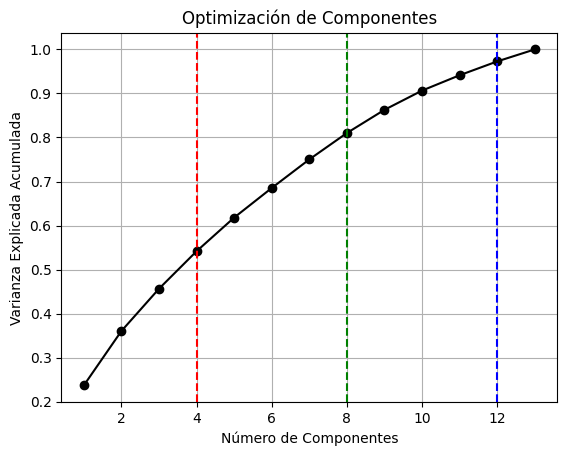

In [148]:
#Code taken from lesson

# Plot the cumulative explained variance
plt.plot(
    range(1, len(cumulative_explained_variance_ratio) + 1),
    cumulative_explained_variance_ratio,
    marker="o",
    color="black",
)
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Optimización de Componentes")
plt.grid(True)

# Add vertical dashed lines
plt.axvline(x=4, color="r", linestyle="--", label="Line at 2")
plt.axvline(x=8, color="g", linestyle="--", label="Line at 3")
plt.axvline(x=12, color="b", linestyle="--", label="Line at 4")
plt.show()

In [149]:
#Based on the plot I will select 12 components to train the model
optimal_components = 12

In [150]:
#Traning the model
pca_model = PCA(data=data_clean, ncomp=optimal_components, standardize=True, normalize=True)

In [151]:
# PCA-transformed data (the principal component scores)
pca_transformed_data = pca_model.factors

In [152]:
# The loading matrix (eigenvectors)
loading_matrix = pca_model.loadings

In [153]:
#Using data_clean to extract mean and desv. standard
data_mean = np.mean(data_clean, axis=0)
data_std = np.std(data_clean, axis=0)

In [154]:
# Inverse transformation
approx_original_data_standardized = np.dot(pca_transformed_data, loading_matrix.T)

In [155]:
# If the data was standardized, you need to unstandardize it (reverse the scaling and centering)
approx_original_data = approx_original_data_standardized * data_std + data_mean

In [156]:
#Confirming the shape
approx_original_data.shape

(297, 13)

In [157]:
data_pca_train = pd.DataFrame(approx_original_data, columns=data[data.columns[:13]].columns) # Convert to Dataframe

In [158]:
data_pca_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,55.037122,0.691894,3.032196,131.862961,246.629514,0.192075,1.048454,149.803733,0.306989,1.112784,1.676148,0.615420,4.804341
1,54.810348,0.699234,3.178095,133.199541,248.886779,0.133640,1.041402,147.155110,0.354557,1.096658,1.581455,0.783583,4.540671
2,55.249956,0.688397,3.178977,130.693159,245.658912,0.133691,1.048198,149.606177,0.358463,1.105876,1.613501,0.734560,4.809525
3,53.617243,0.699903,3.169037,131.673462,248.551258,0.141357,0.936605,151.803022,0.304053,1.246449,1.669816,0.640196,4.587848
4,53.806220,0.639422,3.104470,131.909424,244.609758,0.133947,1.061348,150.724466,0.323120,1.049248,1.603820,0.684561,4.669063


In [159]:
#Creating a function to fill out nulls based on the trained PCA model

def fill_na(imputed_df,df_nulls, lm, data_mean, data_std):
  new_data_standardized = (imputed_df - data_mean) / data_std #Std Scaling
  new_data_transformed = np.dot(new_data_standardized , lm) #Transformation
  approx_new_data_standardized = np.dot(new_data_transformed, lm.T) #Inverse Transformation
  approx_new_data = approx_new_data_standardized * data_std + data_mean #Unscaling
  array_pca = pd.DataFrame(approx_new_data , columns=df_nulls.columns)
  array_filled_pca = df_nulls.fillna(array_pca)
  return array_filled_pca

In [160]:
filled_pca={}
for i in populated:
  new_pca_nm=i+'_pca'
  filled_pca[new_pca_nm]=fill_na(populated[i],dict[i[0]].copy(),loading_matrix,data_mean,data_std)

In [161]:
#Confirm no more nulls after filling up with PCA all ht eimputed datasets
for i in filled_pca:
  print(i + '  [Shape: ' + str(filled_pca[i].shape) + ', Missing values: ' + str(filled_pca[i].isna().sum().sum()) + ']')

A_avg_pca  [Shape: (297, 13), Missing values: 0]
A_gauss_pca  [Shape: (297, 13), Missing values: 0]
A_median_pca  [Shape: (297, 13), Missing values: 0]
B_avg_pca  [Shape: (297, 13), Missing values: 0]
B_gauss_pca  [Shape: (297, 13), Missing values: 0]
B_median_pca  [Shape: (297, 13), Missing values: 0]
C_avg_pca  [Shape: (297, 13), Missing values: 0]
C_gauss_pca  [Shape: (297, 13), Missing values: 0]
C_median_pca  [Shape: (297, 13), Missing values: 0]


In [162]:
#Dataframe to compare each of the populated datasets vs each other.
matrix_filled_pca=[]
for i in filled_pca:
  matrix_filled_pca.append(i)
comparison_filled_pca=pd.DataFrame(columns=matrix_filled_pca,index=matrix_filled_pca)

In [163]:
#Populate comparison between datasets populated with PCA
for i in matrix_filled_pca:
  for j in matrix_filled_pca:
    sc=score(filled_pca,filled_pca,i,j)
    comparison_filled_pca.loc[i,j]=sc

In [164]:
#Let's take a look into the NMSRE scores of the datasets populated with PCA model to make sure we are no generated duplicated matrix
comparison_filled_pca

,A_avg_pca,A_gauss_pca,A_median_pca,B_avg_pca,B_gauss_pca,B_median_pca,C_avg_pca,C_gauss_pca,C_median_pca
A_avg_pca,0.0,0.06336,0.048987,0.099164,0.108347,0.113909,0.140709,0.131212,0.156296
A_gauss_pca,0.088179,0.0,0.102209,0.134215,0.122248,0.145096,0.167465,0.140167,0.18046
A_median_pca,0.052224,0.07508,0.0,0.116433,0.113532,0.109849,0.153594,0.134803,0.153355
B_avg_pca,0.096982,0.095281,0.108959,0.0,0.082479,0.054346,0.099076,0.114149,0.123605
B_gauss_pca,0.168988,0.138558,0.171225,0.133947,0.0,0.14373,0.167297,0.138655,0.179444
B_median_pca,0.116775,0.10685,0.106816,0.058012,0.091106,0.0,0.120756,0.119139,0.105957
C_avg_pca,0.137401,0.118778,0.143434,0.098654,0.103727,0.115045,0.0,0.094453,0.066309
C_gauss_pca,0.216947,0.167548,0.214953,0.192597,0.145401,0.195126,0.161536,0.0,0.173442
C_median_pca,0.159584,0.132689,0.148872,0.128913,0.114404,0.10539,0.07066,0.103671,0.0


In [165]:
#Let's calculate scores of the datasets populated with avg and gauss vs original dataset
nmrse_scores_imputed=pd.DataFrame(columns=['df_1','df_2','Score'])
original={'Original':data[data.columns[:13]]}
for i in populated:
  for j in original:
    s=score(populated,original,i,j)
    new_row = {"df_1":[i] , "df_2":[j], 'Score':[s] }
    df2 = pd.DataFrame(new_row)
    nmrse_scores_imputed=pd.concat([nmrse_scores_imputed, df2], ignore_index = True)

In [166]:
#Ranking by best score for the datasets populated with mean, gauss and median
nmrse_scores_imputed.sort_values(by='Score', ignore_index=True)

,df_1,df_2,Score
0,A_avg,Original,0.093589
1,A_median,Original,0.113012
2,A_gauss,Original,0.131660
3,B_avg,Original,0.136365
4,B_median,Original,0.153583
5,C_avg,Original,0.168482
6,C_median,Original,0.189708
7,B_gauss,Original,0.199616
8,C_gauss,Original,0.242219


## Based on the above table the best 'dummie' method to imput missing data (for each dataset: A, B ,C) is the mean, followed by the median. The Gauss distribution is the worst in terms of scores.

In [167]:
#Let's calculate the scores for each dataset populated with PCA vs the original data
nmrse_scores_filled_pca=pd.DataFrame(columns=['df_1','df_2','Score'])
original={'Original':data[data.columns[:13]]}
for i in filled_pca:
  for j in original:
    s=score(filled_pca,original,i,j)
    new_row = {"df_1":[i] , "df_2":[j], 'Score':[s] }
    df2 = pd.DataFrame(new_row)
    nmrse_scores_filled_pca=pd.concat([nmrse_scores_filled_pca, df2], ignore_index = True)

In [168]:
#Sorting scores for datasets filled with PCA
nmrse_scores_filled_pca.sort_values(by='Score', ignore_index=True)

,df_1,df_2,Score
0,A_avg_pca,Original,0.090595
1,A_median_pca,Original,0.109297
2,A_gauss_pca,Original,0.125290
3,B_avg_pca,Original,0.133512
4,B_median_pca,Original,0.148584
5,C_avg_pca,Original,0.165128
6,C_median_pca,Original,0.184060
7,B_gauss_pca,Original,0.192387
8,C_gauss_pca,Original,0.233774


## Best imputing methods for datasets A, B and C for PCA transformation (based on scores):
1.- AVG

2.- Median

3.- Gauss

In [169]:
nmrse_scores_all=pd.concat([nmrse_scores_filled_pca,nmrse_scores_imputed],ignore_index=True)

In [170]:
#Sorting the scores starting with the best one (All methods, all % of missing entries: Imputed vs PCA )
nmrse_scores_all.sort_values(by='Score', ignore_index=True)

,df_1,df_2,Score
0,A_avg_pca,Original,0.090595
1,A_avg,Original,0.093589
2,A_median_pca,Original,0.109297
3,A_median,Original,0.113012
4,A_gauss_pca,Original,0.125290
5,A_gauss,Original,0.131660
6,B_avg_pca,Original,0.133512
7,B_avg,Original,0.136365
8,B_median_pca,Original,0.148584
9,B_median,Original,0.153583


## Based on the scores among the imputation methods and its tranform datasets, I conclude that is worth it checking the scores between the imputation method and the original data before the transformation with the PCA, since the imputing method with the best score will ended up generating the best PCA transformation.

# Let's try another metric to measure accuracy

#Autoencoder

In [171]:
BATCH_SIZE=16

In [172]:
#Converting datasets into pytorch tensor
minmax_scaler_ytrain = MinMaxScaler()
data_clean_minmax = minmax_scaler_ytrain.fit_transform(data_clean)
data_clean_tensor = torch.tensor(data_clean_minmax, dtype=torch.float32)

In [173]:
populated_tensors={}
for i in populated:
  t_nm=i+'_tensor'
  temp_minmax = minmax_scaler_ytrain.fit_transform(populated[i])
  temp_tensor= torch.tensor(temp_minmax, dtype=torch.float32)
  populated_tensors[t_nm]=temp_tensor

In [174]:
# Defining the ratio for splitting between training and validation sets
validation_ratio = 0.1

In [175]:
# Calculating the size of the validation set
validation_size = int(validation_ratio * len(populated_tensors['A_avg_tensor']))
training_size = len(populated_tensors['A_avg_tensor']) - validation_size

In [176]:
# Use random_split to create training and validation datasets
train_dataset, val_dataset = random_split(dataset=TensorDataset(data_clean_tensor), lengths=[training_size, validation_size])

In [177]:
# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [178]:
# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [179]:
# Set input and hidden size based on your data
input_size = data_clean_minmax.shape[1]
hidden_size = int(input_size / 2)

In [180]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [181]:
# Instantiate the model
model_ae = Autoencoder(input_size, hidden_size)
dev = "cuda" if device == "cuda:0" else "cpu"
summary(model_ae.to(device), (input_size,), batch_size=BATCH_SIZE, device=dev)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [16, 6]              84
            Linear-2                   [16, 13]              91
Total params: 175
Trainable params: 175
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [182]:
def train_eval(model, loader, optimizer, loss_func):
    total_loss_train = []
    total_loss_val = []

    # Model in training mode:
    if model.training:
        for batch_idx, data in tqdm(
            enumerate(loader), desc="Epoch_Train", total=len(loader)
        ):
            optimizer.zero_grad(set_to_none=True)

            # Forward pass
            input_data = data[0].to(device)
            output = model(input_data)
            loss_train = loss_func(output, input_data)

            # Check for NaN in loss
            if np.isnan(loss_train.item()):
                print("NaN loss value detected. Aborting training.")
                break

            # Backward pass and optimization
            loss_train.backward()
            optimizer.step()
            total_loss_train.append(loss_train.item())

        return total_loss_train

    # Model in evaluation mode:
    elif not model.training:
        for batch_idx, data in tqdm(
            enumerate(loader), desc="Epoch_Val", total=len(loader)
        ):
            input_data = data[0].to(device)
            outputs = model(input_data)
            loss_val = loss_func(outputs, input_data)
            total_loss_val.append(loss_val.item())
        return total_loss_val


def calc_loss(loss_list, total_loss):
    loss_list.append(sum(total_loss) / len(total_loss))
    return loss_list

In [198]:
# Hiperparámetros
EPOCHS = 150
LR = 0.0001

In [199]:
loss = nn.MSELoss().to(device)
optimizer = optim.Adam(model_ae.parameters(), lr=LR)

In [200]:
# Reset model parameters
def reset_model_parameters(model):
    for layer in model.children():
        if hasattr(layer, "reset_parameters"):
            layer.reset_parameters()

In [201]:
reset_model_parameters(model_ae)

In [202]:
%%time

torch.cuda.empty_cache()

# Lists
loss_list_train = []
loss_list_val = []

# Training and Evaluation
for epoch in range(EPOCHS):
    # Train Iterations
    model = model_ae.train()
    total_loss_train = train_eval(model_ae, train_loader, optimizer, loss)

    # Val Iterations
    model = model.eval()
    with torch.no_grad():
        total_loss_val = train_eval(model_ae, val_loader, optimizer, loss)

    # Calc Loss
    loss_list_train = calc_loss(loss_list_train, total_loss_train)
    loss_list_val = calc_loss(loss_list_val, total_loss_val)

    # Printing Metrics per Epoch
    print(f"Training [{100.0 *(epoch+1)/EPOCHS:.0f}%]\t\tTrain Loss:{loss_list_train[-1]:.4f}  Val Loss:{loss_list_val[-1]:.4f}\n")

Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [1%]		Train Loss:0.3814  Val Loss:0.3701



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [1%]		Train Loss:0.3743  Val Loss:0.3618



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [2%]		Train Loss:0.3659  Val Loss:0.3538



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [3%]		Train Loss:0.3586  Val Loss:0.3462



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [3%]		Train Loss:0.3502  Val Loss:0.3389



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [4%]		Train Loss:0.3447  Val Loss:0.3317



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [5%]		Train Loss:0.3366  Val Loss:0.3247



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [5%]		Train Loss:0.3303  Val Loss:0.3179



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [6%]		Train Loss:0.3236  Val Loss:0.3113



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [7%]		Train Loss:0.3175  Val Loss:0.3048



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [7%]		Train Loss:0.3113  Val Loss:0.2983



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [8%]		Train Loss:0.3038  Val Loss:0.2919



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [9%]		Train Loss:0.2991  Val Loss:0.2857



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [9%]		Train Loss:0.2933  Val Loss:0.2795



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [10%]		Train Loss:0.2865  Val Loss:0.2733



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [11%]		Train Loss:0.2800  Val Loss:0.2673



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [11%]		Train Loss:0.2749  Val Loss:0.2613



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [12%]		Train Loss:0.2688  Val Loss:0.2553



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [13%]		Train Loss:0.2623  Val Loss:0.2493



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [13%]		Train Loss:0.2572  Val Loss:0.2433



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [14%]		Train Loss:0.2510  Val Loss:0.2376



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [15%]		Train Loss:0.2451  Val Loss:0.2318



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [15%]		Train Loss:0.2394  Val Loss:0.2261



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [16%]		Train Loss:0.2332  Val Loss:0.2204



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [17%]		Train Loss:0.2277  Val Loss:0.2147



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [17%]		Train Loss:0.2223  Val Loss:0.2093



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [18%]		Train Loss:0.2178  Val Loss:0.2039



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [19%]		Train Loss:0.2120  Val Loss:0.1986



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [19%]		Train Loss:0.2069  Val Loss:0.1933



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [20%]		Train Loss:0.2014  Val Loss:0.1882



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [21%]		Train Loss:0.1965  Val Loss:0.1832



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [21%]		Train Loss:0.1909  Val Loss:0.1783



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [22%]		Train Loss:0.1856  Val Loss:0.1735



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [23%]		Train Loss:0.1813  Val Loss:0.1690



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [23%]		Train Loss:0.1769  Val Loss:0.1646



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [24%]		Train Loss:0.1723  Val Loss:0.1603



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [25%]		Train Loss:0.1682  Val Loss:0.1560



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [25%]		Train Loss:0.1634  Val Loss:0.1520



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [26%]		Train Loss:0.1597  Val Loss:0.1482



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [27%]		Train Loss:0.1560  Val Loss:0.1445



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [27%]		Train Loss:0.1521  Val Loss:0.1409



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [28%]		Train Loss:0.1486  Val Loss:0.1375



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [29%]		Train Loss:0.1450  Val Loss:0.1343



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [29%]		Train Loss:0.1419  Val Loss:0.1313



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [30%]		Train Loss:0.1385  Val Loss:0.1284



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [31%]		Train Loss:0.1355  Val Loss:0.1256



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [31%]		Train Loss:0.1328  Val Loss:0.1229



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [32%]		Train Loss:0.1298  Val Loss:0.1205



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [33%]		Train Loss:0.1273  Val Loss:0.1181



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [33%]		Train Loss:0.1251  Val Loss:0.1160



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [34%]		Train Loss:0.1228  Val Loss:0.1139



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [35%]		Train Loss:0.1203  Val Loss:0.1120



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [35%]		Train Loss:0.1187  Val Loss:0.1102



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [36%]		Train Loss:0.1162  Val Loss:0.1085



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [37%]		Train Loss:0.1145  Val Loss:0.1070



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [37%]		Train Loss:0.1129  Val Loss:0.1056



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [38%]		Train Loss:0.1112  Val Loss:0.1043



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [39%]		Train Loss:0.1098  Val Loss:0.1031



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [39%]		Train Loss:0.1083  Val Loss:0.1019



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [40%]		Train Loss:0.1065  Val Loss:0.1008



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [41%]		Train Loss:0.1059  Val Loss:0.0999



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [41%]		Train Loss:0.1047  Val Loss:0.0990



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [42%]		Train Loss:0.1037  Val Loss:0.0981



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [43%]		Train Loss:0.1029  Val Loss:0.0974



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [43%]		Train Loss:0.1014  Val Loss:0.0967



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [44%]		Train Loss:0.1008  Val Loss:0.0960



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [45%]		Train Loss:0.1000  Val Loss:0.0954



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [45%]		Train Loss:0.0993  Val Loss:0.0948



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [46%]		Train Loss:0.0986  Val Loss:0.0943



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [47%]		Train Loss:0.0976  Val Loss:0.0938



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [47%]		Train Loss:0.0975  Val Loss:0.0933



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [48%]		Train Loss:0.0967  Val Loss:0.0929



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [49%]		Train Loss:0.0960  Val Loss:0.0925



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [49%]		Train Loss:0.0954  Val Loss:0.0922



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [50%]		Train Loss:0.0951  Val Loss:0.0919



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [51%]		Train Loss:0.0948  Val Loss:0.0915



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [51%]		Train Loss:0.0944  Val Loss:0.0912



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [52%]		Train Loss:0.0932  Val Loss:0.0909



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [53%]		Train Loss:0.0928  Val Loss:0.0906



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [53%]		Train Loss:0.0926  Val Loss:0.0903



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [54%]		Train Loss:0.0921  Val Loss:0.0901



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [55%]		Train Loss:0.0918  Val Loss:0.0898



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [55%]		Train Loss:0.0916  Val Loss:0.0896



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [56%]		Train Loss:0.0915  Val Loss:0.0893



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [57%]		Train Loss:0.0910  Val Loss:0.0891



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [57%]		Train Loss:0.0904  Val Loss:0.0888



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [58%]		Train Loss:0.0904  Val Loss:0.0886



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [59%]		Train Loss:0.0899  Val Loss:0.0884



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [59%]		Train Loss:0.0897  Val Loss:0.0881



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [60%]		Train Loss:0.0895  Val Loss:0.0879



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [61%]		Train Loss:0.0891  Val Loss:0.0877



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [61%]		Train Loss:0.0889  Val Loss:0.0875



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [62%]		Train Loss:0.0883  Val Loss:0.0873



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [63%]		Train Loss:0.0883  Val Loss:0.0871



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [63%]		Train Loss:0.0879  Val Loss:0.0868



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [64%]		Train Loss:0.0878  Val Loss:0.0866



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [65%]		Train Loss:0.0870  Val Loss:0.0864



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [65%]		Train Loss:0.0868  Val Loss:0.0862



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [66%]		Train Loss:0.0865  Val Loss:0.0860



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [67%]		Train Loss:0.0864  Val Loss:0.0858



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [67%]		Train Loss:0.0859  Val Loss:0.0855



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [68%]		Train Loss:0.0858  Val Loss:0.0853



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [69%]		Train Loss:0.0858  Val Loss:0.0851



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [69%]		Train Loss:0.0853  Val Loss:0.0849



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [70%]		Train Loss:0.0852  Val Loss:0.0847



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [71%]		Train Loss:0.0849  Val Loss:0.0845



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [71%]		Train Loss:0.0845  Val Loss:0.0843



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [72%]		Train Loss:0.0843  Val Loss:0.0841



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [73%]		Train Loss:0.0843  Val Loss:0.0838



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [73%]		Train Loss:0.0839  Val Loss:0.0836



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [74%]		Train Loss:0.0836  Val Loss:0.0834



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [75%]		Train Loss:0.0834  Val Loss:0.0832



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [75%]		Train Loss:0.0833  Val Loss:0.0830



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [76%]		Train Loss:0.0829  Val Loss:0.0828



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [77%]		Train Loss:0.0826  Val Loss:0.0825



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [77%]		Train Loss:0.0827  Val Loss:0.0823



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [78%]		Train Loss:0.0822  Val Loss:0.0821



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [79%]		Train Loss:0.0820  Val Loss:0.0819



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [79%]		Train Loss:0.0818  Val Loss:0.0817



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [80%]		Train Loss:0.0813  Val Loss:0.0814



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [81%]		Train Loss:0.0814  Val Loss:0.0812



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [81%]		Train Loss:0.0811  Val Loss:0.0810



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [82%]		Train Loss:0.0807  Val Loss:0.0808



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [83%]		Train Loss:0.0804  Val Loss:0.0805



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [83%]		Train Loss:0.0803  Val Loss:0.0803



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [84%]		Train Loss:0.0801  Val Loss:0.0801



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [85%]		Train Loss:0.0798  Val Loss:0.0799



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [85%]		Train Loss:0.0795  Val Loss:0.0797



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [86%]		Train Loss:0.0793  Val Loss:0.0795



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [87%]		Train Loss:0.0792  Val Loss:0.0792



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [87%]		Train Loss:0.0788  Val Loss:0.0790



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [88%]		Train Loss:0.0784  Val Loss:0.0788



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [89%]		Train Loss:0.0785  Val Loss:0.0785



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [89%]		Train Loss:0.0781  Val Loss:0.0783



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [90%]		Train Loss:0.0784  Val Loss:0.0781



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [91%]		Train Loss:0.0777  Val Loss:0.0779



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [91%]		Train Loss:0.0776  Val Loss:0.0776



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [92%]		Train Loss:0.0773  Val Loss:0.0774



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [93%]		Train Loss:0.0775  Val Loss:0.0772



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [93%]		Train Loss:0.0767  Val Loss:0.0770



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [94%]		Train Loss:0.0767  Val Loss:0.0767



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [95%]		Train Loss:0.0760  Val Loss:0.0765



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [95%]		Train Loss:0.0761  Val Loss:0.0763



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [96%]		Train Loss:0.0759  Val Loss:0.0761



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [97%]		Train Loss:0.0758  Val Loss:0.0758



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [97%]		Train Loss:0.0752  Val Loss:0.0756



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [98%]		Train Loss:0.0752  Val Loss:0.0754



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [99%]		Train Loss:0.0751  Val Loss:0.0751



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [99%]		Train Loss:0.0747  Val Loss:0.0749



Epoch_Train:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/2 [00:00<?, ?it/s]

Training [100%]		Train Loss:0.0745  Val Loss:0.0747

CPU times: user 12 s, sys: 354 ms, total: 12.3 s
Wall time: 15.6 s


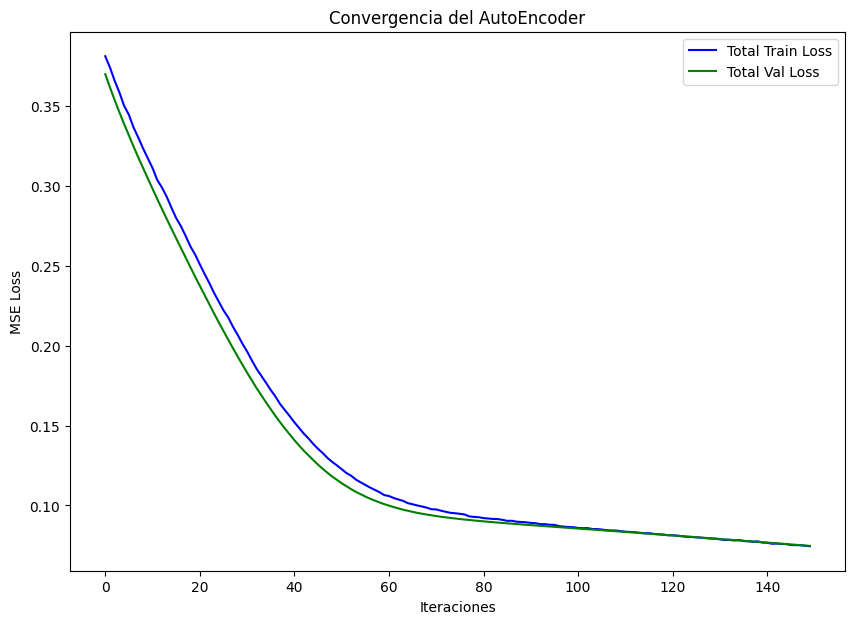

In [203]:
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(loss_list_train, "b", label="Total Train Loss")
ax1.plot(loss_list_val, "g", label="Total Val Loss")
plt.title("Convergencia del AutoEncoder", color="black")
ax1.set_xlabel("Iteraciones")
ax1.set_ylabel("MSE Loss", color="black")
ax1.legend(loc="upper right")
plt.show()

In [204]:
#Filling missing values
model_ae.eval()
filled_tensors={}
with torch.no_grad():
    for i in populated_tensors:
      name_temp=i+'_filled'
      filled_tensors[name_temp] = model_ae(populated_tensors[i].to(device))
      filled_tensors[name_temp]= minmax_scaler_ytrain.inverse_transform(filled_tensors[name_temp].cpu().numpy())

In [205]:
trained_ae={}
filled_ae={}
for i in populated:
  t=i+'_tensor_filled'
  new_nm=i+'_trained_ae'
  new_nm_f=i+'_filled_ae'
  o=i[0:1]
  trained_ae[new_nm] = pd.DataFrame(filled_tensors[t], columns=populated[i].columns)
  filled_ae[new_nm_f]= dict[o].fillna(trained_ae[new_nm])

In [214]:
#Confirm that no more nulls after filling up with AE all the imputed datasets
for i in filled_ae:
  print(i + '  [Shape: ' + str(filled_ae[i].shape) + ', Missing values: ' + str(filled_ae[i].isna().sum().sum()) + ']')

A_avg_filled_ae  [Shape: (297, 13), Missing values: 0]
A_gauss_filled_ae  [Shape: (297, 13), Missing values: 0]
A_median_filled_ae  [Shape: (297, 13), Missing values: 0]
B_avg_filled_ae  [Shape: (297, 13), Missing values: 0]
B_gauss_filled_ae  [Shape: (297, 13), Missing values: 0]
B_median_filled_ae  [Shape: (297, 13), Missing values: 0]
C_avg_filled_ae  [Shape: (297, 13), Missing values: 0]
C_gauss_filled_ae  [Shape: (297, 13), Missing values: 0]
C_median_filled_ae  [Shape: (297, 13), Missing values: 0]


In [206]:
#Dataframe to compare each of the populated datasets vs each other.
matrix_filled_ae=[]
for i in filled_ae:
  matrix_filled_ae.append(i)
  comparison_filled_ae=pd.DataFrame(columns=matrix_filled_ae,index=matrix_filled_ae)

In [208]:
#Populate comparison between datasets populated with AE
for i in matrix_filled_ae:
  for j in matrix_filled_ae:
    sc=score(filled_ae,filled_ae,i,j)
    comparison_filled_ae.loc[i,j]=sc

In [209]:
comparison_filled_ae

,A_avg_filled_ae,A_gauss_filled_ae,A_median_filled_ae,B_avg_filled_ae,B_gauss_filled_ae,B_median_filled_ae,C_avg_filled_ae,C_gauss_filled_ae,C_median_filled_ae
A_avg_filled_ae,0.0,0.025571,0.015928,0.103827,0.110954,0.10496,0.145953,0.156042,0.147569
A_gauss_filled_ae,0.025297,0.0,0.034608,0.107034,0.109522,0.109939,0.147983,0.153903,0.151077
A_median_filled_ae,0.015971,0.035039,0.0,0.10534,0.113034,0.104237,0.146944,0.15782,0.146949
B_avg_filled_ae,0.101612,0.106104,0.102812,0.0,0.041601,0.021515,0.101877,0.117251,0.105731
B_gauss_filled_ae,0.107145,0.10704,0.108852,0.040832,0.0,0.05147,0.109377,0.109909,0.116113
B_median_filled_ae,0.103021,0.109315,0.101983,0.021602,0.052606,0.0,0.104611,0.123347,0.102766
C_avg_filled_ae,0.14191,0.145625,0.142452,0.101115,0.110279,0.103477,0.0,0.057557,0.029508
C_gauss_filled_ae,0.150456,0.150024,0.15172,0.115031,0.109456,0.12056,0.056771,0.0,0.072897
C_median_filled_ae,0.144755,0.149993,0.143681,0.105936,0.118182,0.102596,0.02976,0.074602,0.0


In [210]:
#Let's calculate the scores for each dataset populated with PCA vs the original data
nmrse_scores_filled_ae=pd.DataFrame(columns=['df_1','df_2','Score'])
original={'Original':data[data.columns[:13]]}
for i in filled_ae:
  for j in original:
    s=score(filled_ae,original,i,j)
    new_row = {"df_1":[i] , "df_2":[j], 'Score':[s] }
    df2 = pd.DataFrame(new_row)
    nmrse_scores_filled_ae=pd.concat([nmrse_scores_filled_ae, df2], ignore_index = True)

In [211]:
nmrse_scores_filled_ae.sort_values(by=['Score'], ignore_index=True)

,df_1,df_2,Score
0,A_avg_filled_ae,Original,0.095304
1,A_gauss_filled_ae,Original,0.095376
2,A_median_filled_ae,Original,0.097689
3,B_avg_filled_ae,Original,0.140560
4,B_median_filled_ae,Original,0.142156
5,B_gauss_filled_ae,Original,0.142161
6,C_avg_filled_ae,Original,0.172720
7,C_median_filled_ae,Original,0.175690
8,C_gauss_filled_ae,Original,0.177105


In [212]:
nmrse_scores_all_plus_ae=pd.concat([nmrse_scores_filled_pca,nmrse_scores_imputed,nmrse_scores_filled_ae],ignore_index=True)

In [213]:
nmrse_scores_all_plus_ae.sort_values(by=['Score'],ignore_index=True)

,df_1,df_2,Score
0,A_avg_pca,Original,0.090595
1,A_avg,Original,0.093589
2,A_avg_filled_ae,Original,0.095304
3,A_gauss_filled_ae,Original,0.095376
4,A_median_filled_ae,Original,0.097689
5,A_median_pca,Original,0.109297
6,A_median,Original,0.113012
7,A_gauss_pca,Original,0.125290
8,A_gauss,Original,0.131660
9,B_avg_pca,Original,0.133512
